In [1]:
from test_hmmbatchcd import *
from test_hmmsgd_metaobs import *

#define epsilon for test_hmmbatchsgd and cd likelihood convergence
epsilon=10**(-8)

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


Hamming Distance =  0.3446666666666667


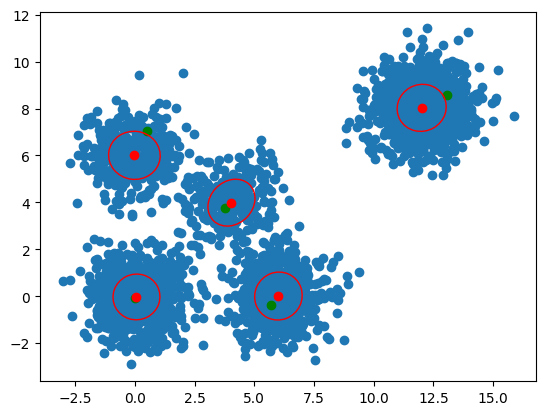

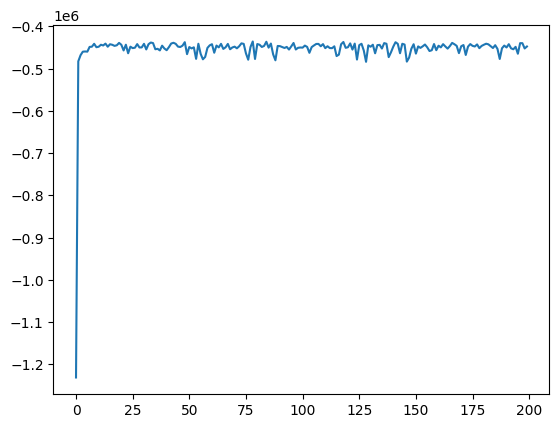

In [2]:
test_hmmsgd_metaobs(maxit=200, metaobs_half=256, mb_sz=1)

Hamming Distance =  0.3343333333333333


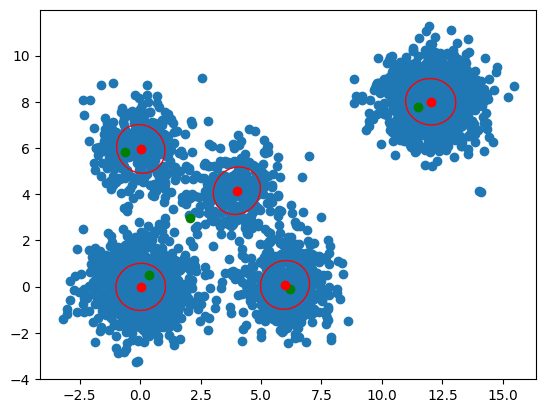

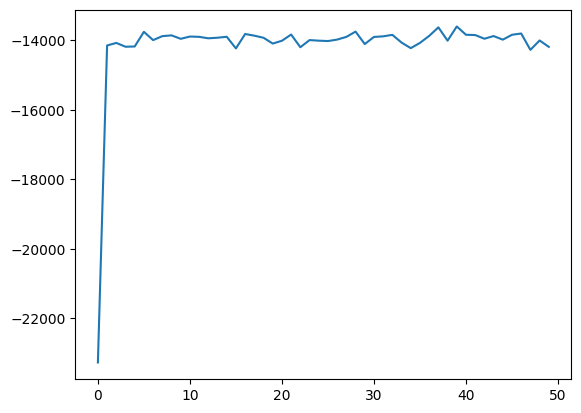

In [3]:
#batch 1X500 - 300 it
test_hmmsgd_metaobs(maxit=50, metaobs_half=1, mb_sz=500)

## Runtime comparison: sgd vs all observations

Hamming Distance =  0.357


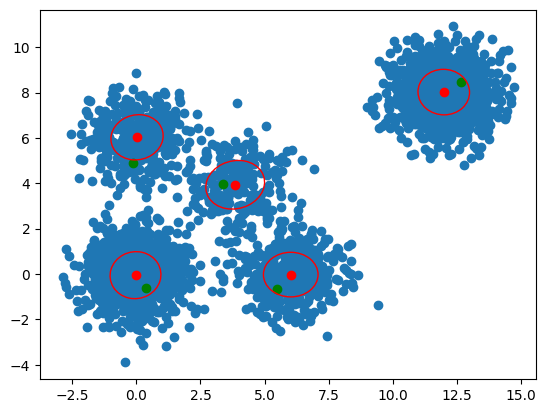

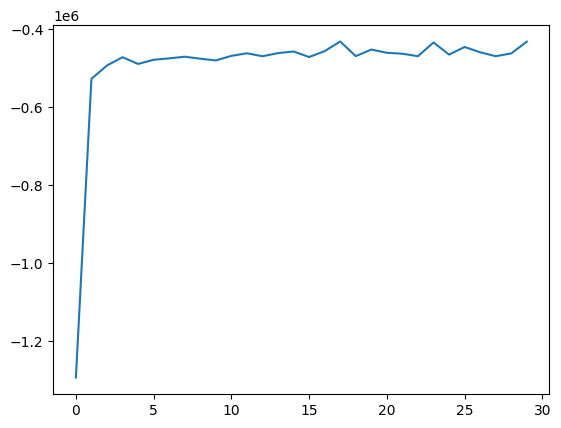

True
terminated early - convergence, 
 elbo : -15456790.431407368 
 lower bound : -15456790.431407368
allclose  = True, diff : 0.0
[11.72388425  8.10066213]
Hamming Distance =  0.4033333333333333


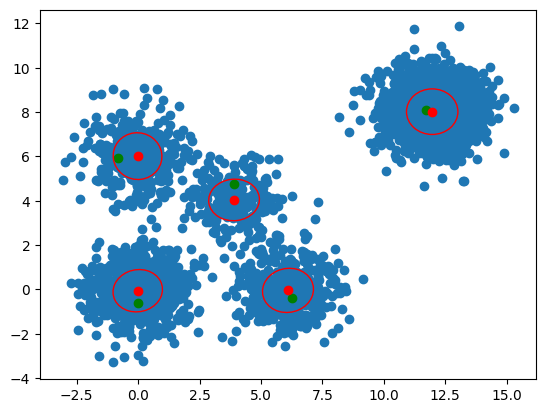

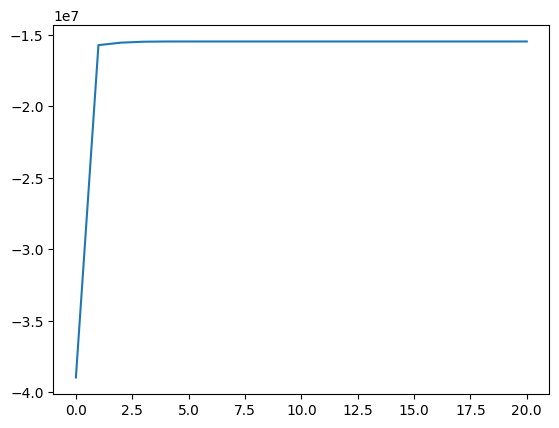

test_hmmbatchsgd() took 0.83 seconds to run
test_hmmbatchcd() took 1.79 seconds to run


In [5]:
from test_hmmbatchcd import *
from test_hmmsgd_metaobs import *
import time

start_time = time.time()
test_hmmsgd_metaobs(maxit=30, metaobs_half=256, mb_sz=1)

end_time = time.time()

elapsed_time_sgd = end_time - start_time

start_time = time.time()

test_hmmbatchcd()

end_time = time.time()
elapsed_time_cd = end_time - start_time

print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

## Zoomed ELBO for SVI

In [138]:
#generate data

import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *
from sklearn.cluster import KMeans


centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])
# T = np.array([[0.8,0.2],[0.3,0.7]])

N = 6000

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)


#####

kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4


# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state

[2.48054296 0.10654266]


Hamming Distance =  0.33516666666666667


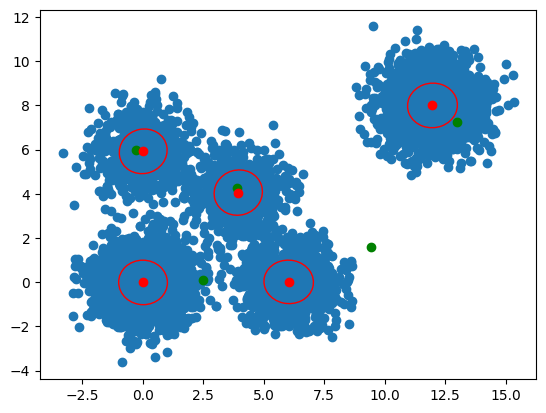

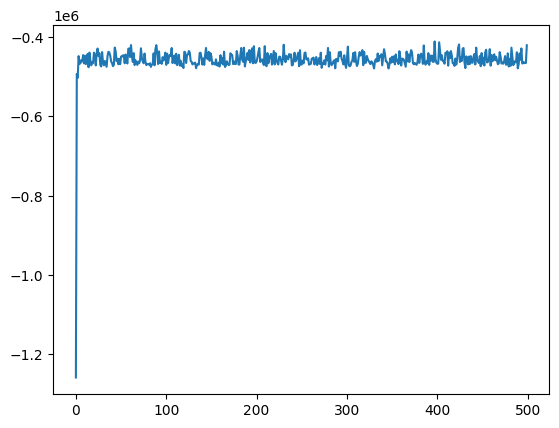

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmsgd_metaobs as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

maxit = 500
metaobs_half = 256
mb_sz = 1

hmm_sgd = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, metaobs_half=metaobs_half, mb_sz=mb_sz)
hmm_sgd.infer()
full_var_x = hmm_sgd.full_local_update()

#sts_true = np.array([int(np.round(i/N)) for i in range(N)])
# hamming distance
print('Hamming Distance = ', hmm_sgd.hamming_dist(full_var_x, seq)[0])

# plot learned emissions over observations
util.plot_emissions(obs, prior_emit, hmm_sgd.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm_sgd.elbo_vec)
plt.show()

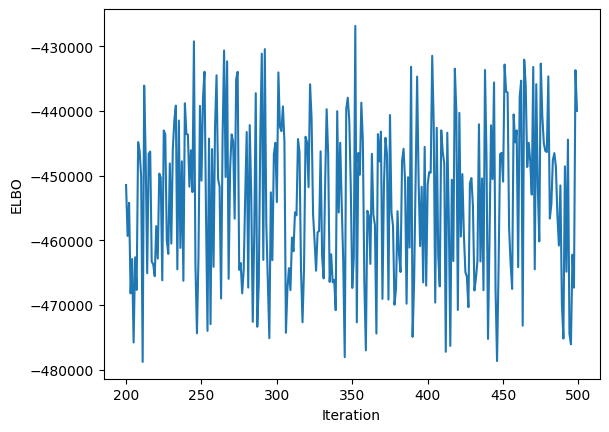

In [104]:
# plot elbo over iterations, zoom with
plt.xlabel('Iteration')
plt.ylabel('ELBO')

plt.plot(np.arange(200,500),hmm_sgd.elbo_vec[200:500])
plt.show()

In [105]:
np.mean(hmm_sgd.elbo_vec[200:500])

-453671.8810096497

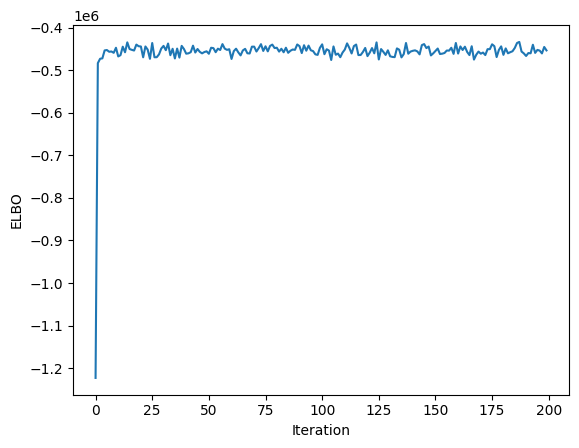

In [6]:
# plot elbo over iterations, zoom with
plt.xlabel('Iteration')
plt.ylabel('ELBO')

plt.plot(hmm_sgd.elbo_vec[0:200])
plt.show()

## hmm distance vs batch_size

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import util
#import hmmbatchcd as HMM
import hmmbatchsgd as HMM

n_reps = 10
distance_cd=0

for i in range(n_reps):

    hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=25, epsilon=10**(-8))  
    hmm.infer() # do inference 
    sts_true = seq # true states 
    
    # hamming distance
    distance_cd += hmm_sgd.hamming_dist(hmm.var_x, seq)[0]

distance_cd = distance_cd/n_reps

print(distance_cd)

0.33483333333333326


In [17]:
import numpy as np

start = 2
stop = 1400
num_steps = 100

log_start = np.log10(start)
log_stop = np.log10(stop)

log_elements = np.geomspace(log_start, log_stop, num=num_steps, endpoint=True)

metaobs_half_list = np.unique(np.floor(np.power(10, log_elements))).astype(int)


metaobs_half_list = list(reversed(list(metaobs_half_list)))

metaobs_half_list.append(1)



In [57]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import hmmsgd_metaobs as SGD_HMM
import time

start_time = time.time()

maxit = 20
mb_sz = 1

n_reps = 100

hmm_distances = []

#loop for different batch sizes
for j, metaobs_half in enumerate(metaobs_half_list):
    
    distance = 0
    
    for i in range(n_reps):
    
        hmm_sgd = SGD_HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, metaobs_half=metaobs_half, mb_sz=mb_sz)
        hmm_sgd.infer()
        full_var_x = hmm_sgd.full_local_update()
        
        distance += hmm_sgd.hamming_dist(full_var_x, seq)[0]

        #distance between prior_emit, hmm_sgd.var_emit
        #print(hmm_sgd.hamming_dist(full_var_x, seq)[0])
        
        if i % 12 == 0:
            print(" ", round(i*100/n_reps, 2), "%")

    distance = distance/n_reps
    hmm_distances.append(distance)
    
    print("Size: ", 2*metaobs_half+1, "// Distance: ", distance)
    
    round_time = time.time() - start_time
    
    print("Runtime: ", round_time, " seconds")
    print("ETA: ", round(round_time*((len(metaobs_half_list)/(j+1)) -1), 1), " seconds"   )

end_time = time.time()
elapsed_time_sgd = end_time - start_time

print(n_reps,elapsed_time_sgd)

  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  2801 // Distance:  0.3330966666666665
Runtime:  138.54928183555603  seconds
ETA:  7620.2  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  2363 // Distance:  0.33305999999999963
Runtime:  262.475239276886  seconds
ETA:  7086.8  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  2003 // Distance:  0.33305499999999955
Runtime:  369.4828727245331  seconds
ETA:  6527.5  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  1703 // Distance:  0.33305166666666636
Runtime:  462.18449687957764  seconds
ETA:  6008.4  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  1453 // Distance:  0.3330649999999998
Runtime:  543.3049335479736  seconds
ETA:  5541.7  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.

  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  23 // Distance:  0.38531333333333356
Runtime:  1561.1420035362244  seconds
ETA:  339.4  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  21 // Distance:  0.39363166666666666
Runtime:  1574.9791204929352  seconds
ETA:  301.6  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  19 // Distance:  0.3896683333333335
Runtime:  1588.9844663143158  seconds
ETA:  264.8  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  17 // Distance:  0.4101566666666667
Runtime:  1602.7135202884674  seconds
ETA:  229.0  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  15 // Distance:  0.41505833333333336
Runtime:  1616.474613904953  seconds
ETA:  194.0  seconds
  0.0 %
  12.0 %
  24.0 %
  36.0 %
  48.0 %
  60.0 %
  72.0 %
  84.0 %
  96.0 %
Size:  13 // Dis

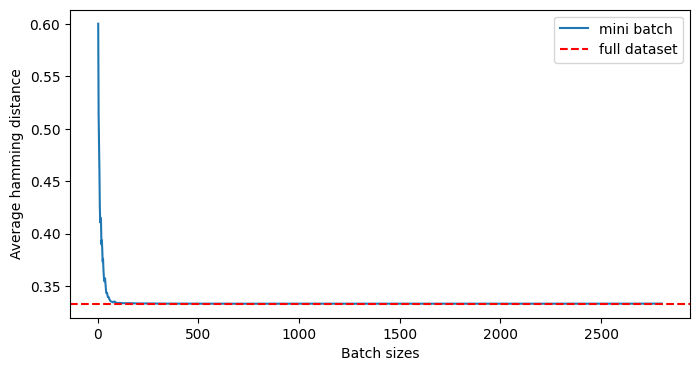

In [58]:
metaobs_list = 2*np.array(metaobs_half_list) + np.ones(len(metaobs_half_list))

plt.figure(figsize=(8, 4))

#plt.yscale('log')  

plt.plot(metaobs_list, hmm_distances, '-', label='mini batch') #'o-'
plt.xlabel('Batch sizes')
plt.ylabel('Average hamming distance')

plt.axhline(distance_cd, color='red', linestyle='--', label='full dataset')
plt.legend()
plt.show()

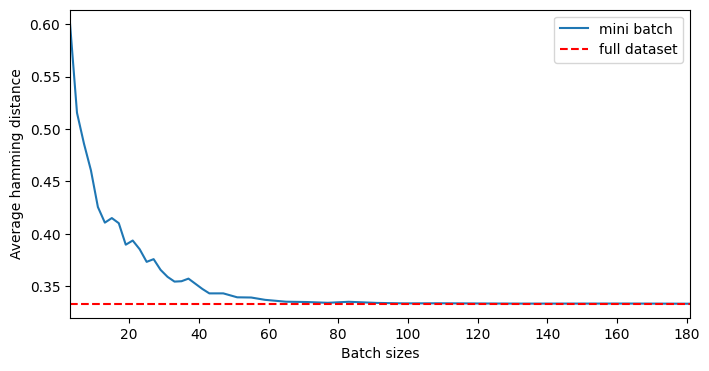

In [107]:
metaobs_list = 2*np.array(metaobs_half_list) + np.ones(len(metaobs_half_list))

plt.figure(figsize=(8, 4))

#plt.yscale('log')  

plt.plot(metaobs_list[20:], hmm_distances[20:], '-', label='mini batch') #'o-'
plt.xlabel('Batch sizes')
plt.ylabel('Average hamming distance')

plt.axhline(distance_cd, color='red', linestyle='--', label='full dataset')
plt.legend()

plt.xlim(metaobs_list[-1],metaobs_list[20])


plt.show()

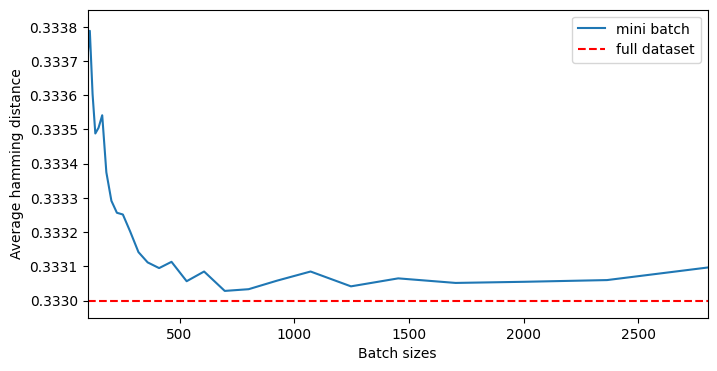

99.0


In [90]:
metaobs_list = 2*np.array(metaobs_half_list) + np.ones(len(metaobs_half_list))

plt.figure(figsize=(8, 4))

#plt.yscale('log')  

plt.plot(metaobs_list[0:27], hmm_distances[0:27], '-', label='mini batch') #'o-'
plt.xlabel('Batch sizes')
plt.ylabel('Average hamming distance')

plt.axhline(distance_cd, color='red', linestyle='--', label='full dataset')
plt.legend()

plt.xlim(metaobs_list[26],metaobs_list[0])
plt.ylim(0.33295,0.33385)
plt.show()

print(metaobs_list[26])

## Runtime comparisons

In [133]:
import hmmbatchcd as HMM
import hmmsgd_metaobs as SGD_HMM

n_reps = 100

start_time = time.time()

###

distance = 0
    
for i in range(n_reps):

    hmm_sgd = SGD_HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=25, metaobs_half=256, mb_sz=1)
    hmm_sgd.infer()
    full_var_x = hmm_sgd.full_local_update()
    
    distance += hmm_sgd.hamming_dist(full_var_x, seq)[0]


distance_sgd = distance/n_reps

###

end_time = time.time()

elapsed_time_sgd = end_time - start_time

start_time = time.time()

###

distance = 0
    
for i in range(n_reps):

    hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=25, epsilon=10**(-8))
    hmm.infer()

    distance += hmm.hamming_dist(hmm.var_x, seq)[0]

distance_cd = distance/n_reps

###

end_time = time.time()

elapsed_time_cd = end_time - start_time

In [134]:
print(elapsed_time_cd/n_reps, elapsed_time_sgd/n_reps)

print(distance_cd, distance_sgd)

2.6673003673553466 0.42838301181793215
0.43516666666666715 0.435335


## Plot comparisons  MCMC, VI full dataset, good/bad SVI 

In [ ]:
# add distribution plot comparison with 
#  MCMC, VI full dataset, good approx SVI with enough batch_size, bad approx SVI with small batch_size

# add 1 or 2 plots of zoomed elbo

# add plot of hmm distance vs batch_size


In [152]:
#generate data

import numpy as np
from pybasicbayes import distributions as dist
from pybasicbayes.distributions import Gaussian
import matplotlib.pyplot as plt
from generate_data import *

centers = np.array([np.array([0,0]),np.array([6,0]),np.array([4,4]),np.array([0,6]),np.array([12,8])])
# centers = [np.array([0,0]),np.array([6,6])]
# centers = [np.array([0,0,0]),np.array([6,0,6]),np.array([4,4,4])]

K = 5           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 0.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0.89,0.01,0.01,0.05,0.04],
    [0.05,0.8,0.05,0.05,0.05],
    [0.05,0.1,0.7,0.05,0.1],
    [0.1,0.1,0.05,0.7,0.05],
    [0.025,0.025,0.025,0.025,0.9]
    ])
# T = np.array([[0.8,0.2],[0.3,0.7]])

N = 6000

emit = make_emissions(centers , kappa_0, nu_0)


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)


[1.89780108 5.32607308]
True
terminated early - convergence, 
 elbo : -63630757.002478205 
 lower bound : -63630757.002478205
allclose  = True, diff : 0.0
[1.89780108 5.32607308]
Hamming Distance =  0.4096666666666667


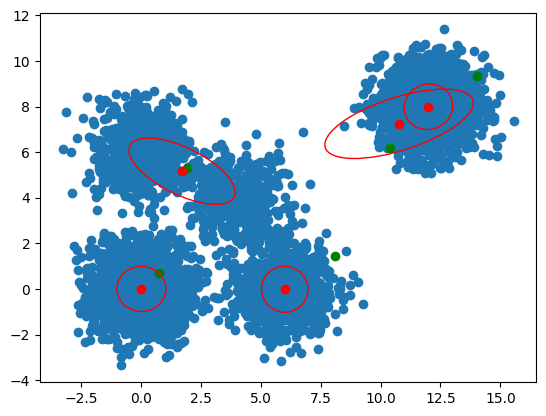

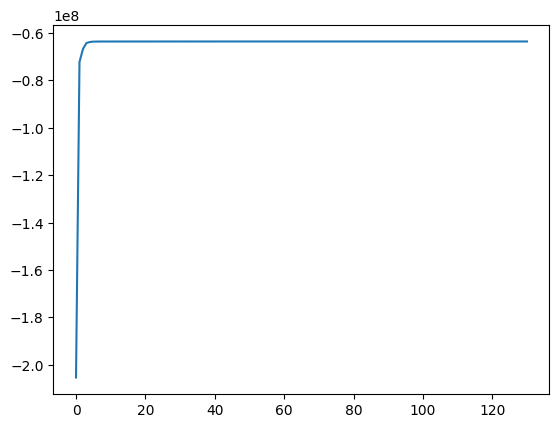

In [153]:
#VI
import time

# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM
import seaborn as sns
from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *
from sklearn.cluster import KMeans


kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=42)
kmeans.fit(obs)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?
print(prior_emit[0].mu_mf)
# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state



start_time = time.time()

hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=1000, epsilon=10**(-12))  
hmm.infer() # do inference 

end_time = time.time()

sts_true = seq # true states 
# hamming distance
print(prior_emit[0].mu_mf)
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

In [154]:
elapsed_time_cd = end_time - start_time
print(elapsed_time_cd)

14.042898654937744


Hamming Distance =  0.4098333333333333


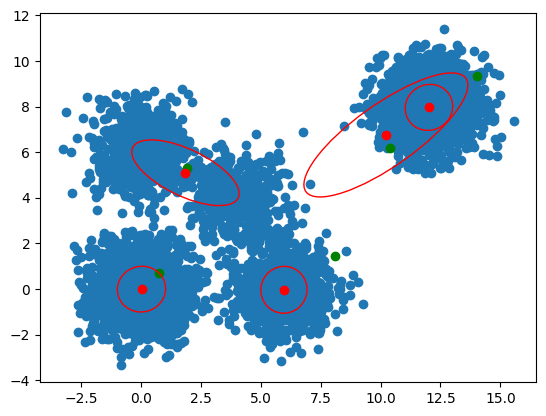

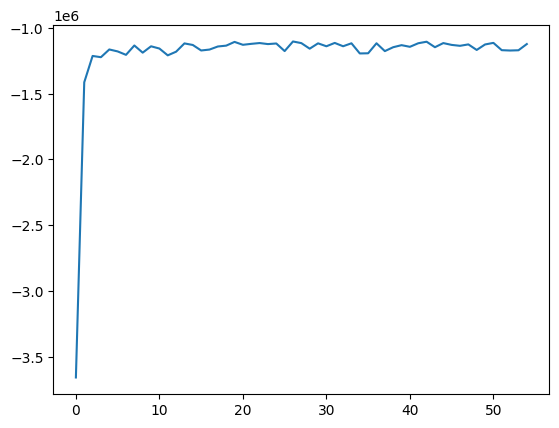

In [155]:
#SVI

#code from test_metaobs
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmsgd_metaobs as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

maxit = 55
metaobs_half = 400
mb_sz = 1

start_time = time.time()

hmm_sgd = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, metaobs_half=metaobs_half, mb_sz=mb_sz)
hmm_sgd.infer()

end_time = time.time()

full_var_x = hmm_sgd.full_local_update()

#sts_true = np.array([int(np.round(i/N)) for i in range(N)])
# hamming distance
print('Hamming Distance = ', hmm_sgd.hamming_dist(full_var_x, seq)[0])

# plot learned emissions over observations
util.plot_emissions(obs, prior_emit, hmm_sgd.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm_sgd.elbo_vec)
plt.show()

In [156]:
elapsed_time_mb = end_time - start_time
print(elapsed_time_mb)

1.1393015384674072


In [157]:
#MCMC
import time
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()

dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":D, "K":K, 'mu_0':np.array([0,0]) ,
        'kappa_0':kappa_0/K, 'nu_0':nu_0,'Psi_0':sigma_0,
        'alpha_0':np.ones((K,K))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
start_time = time.time()

fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 1000 )

end_time = time.time()


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_ms430wpv/model_7dyjzdpz.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.33.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/t

  Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in '/tmp/httpstan_joweni_k/model_7dyjzdpz.stan', line 133, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in '/tmp/httpstan_joweni_k/model_7dyjzdpz.stan', line 133, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditione

In [158]:
elapsed_time_mcmc = end_time - start_time
elapsed_time_mcmc

756.4263663291931

In [159]:
#plot preparation

# for every state extract parameters into a dict 
from scipy.stats import invwishart,t,beta

MCMC_mus = {}
MCMC_sig = {}
MCMC_gamm = {}

true_map_MCMC = [np.argmin(np.sqrt(np.sum((np.mean(fit['mu'][i].T, axis =0)-centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(fit['mu'].shape[0]):
    MCMC_mus[str(true_map_MCMC[i])] = fit['mu'][i].T
    MCMC_sig[str(true_map_MCMC[i])] = fit['Sigma'][i].T
    MCMC_gamm[str(true_map_MCMC[i])] = {}
    for j in range(fit['mu'].shape[0]):
        MCMC_gamm[str(true_map_MCMC[i])][str(true_map_MCMC[j])] = fit['gamma'][i].T[:,j]

VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_tran[i][j]
        
SVI_mus = {}
SVI_sig = {}
SVI_kapp = {}
SVI_nu = {}
SVI_alphas = {}

true_map_SVI = [np.argmin(np.sqrt(np.sum((hmm_sgd.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(fit['mu'].shape[0])]

for i in range(0,len(hmm_sgd.var_emit)):
    SVI_mus[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].mu_mf
    SVI_sig[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].sigma_mf
    SVI_kapp[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].kappa_mf
    SVI_nu[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].nu_mf
    SVI_alphas[str(true_map_SVI[i])] = {}
    for j in range(0,len(hmm_sgd.var_emit)):
        SVI_alphas[str(true_map_SVI[i])][str(true_map_SVI[j])] = hmm_sgd.var_tran[i][j]

KeyError: '3'

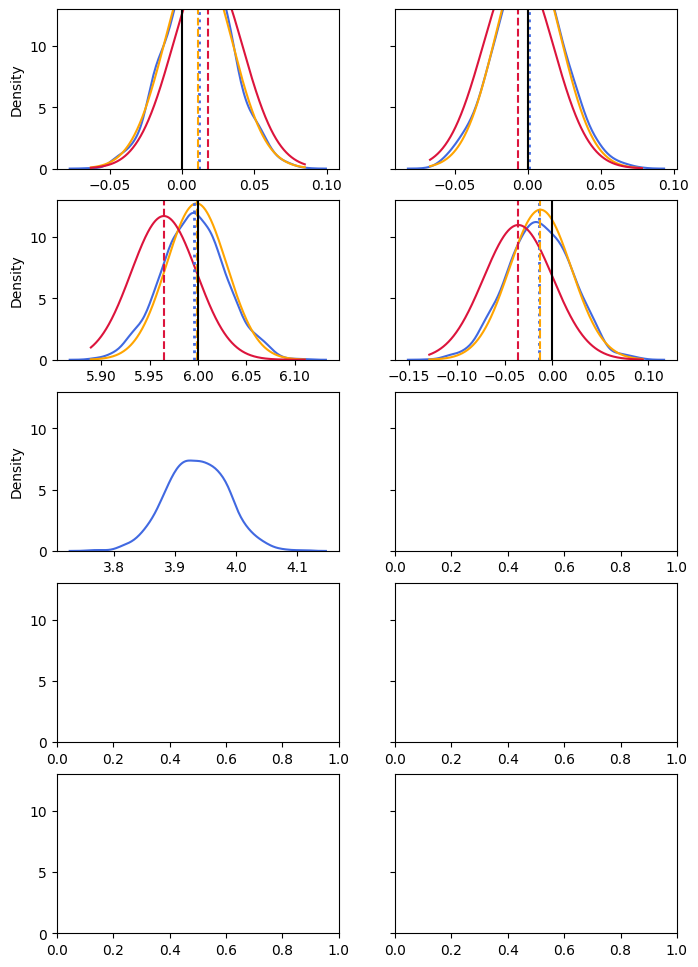

In [160]:
#mus
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(min(MCMC_mus[str(k+1)].T[d]+0.00001),max(MCMC_mus[str(k+1)].T[d]),500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        dist1 = t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))
        ax.plot(x, dist1,label = 'VI',color = 'orange')
        
        #SVI
        scale_kd = np.diag(SVI_sig[str(k+1)])[d] / (SVI_kapp[str(k+1)]*( SVI_nu[str(k+1)] + D - 1 ))
        
        dist2 = t.pdf(x, df = SVI_nu[str(k+1)], loc=SVI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))
        ax.plot(x, dist2,label = 'SVI',color = 'crimson')
        
        h_max = max(np.max(dist2),np.max(dist1), np.max(MCMC_mus[str(k+1)].T[d]))
        
        h_max=13

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0, h_max,linestyles='dotted',linewidth = 2, label='MCMC mean',color = 'royalblue')
        
        ax.vlines(VI_mus[str(k+1)][d],0,h_max,color = 'orange',label='VI',linestyles='dashed')

        ax.vlines(SVI_mus[str(k+1)][d],0,h_max,color = 'crimson',label='SVI',linestyles='dashed')
        
        ax.vlines(centers[k][d],0,h_max,color = 'black',label='truth')
        
        plt.ylim((0,h_max))
        
plt.suptitle('Mus (mean) students-t approximation')
legend = plt.legend(fontsize = 8)
plt.tight_layout()

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)


In [ ]:
#sigmas
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color='royalblue')

        x = np.linspace(0.1,3,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI',color = 'orange')
        
        iw = invwishart.pdf(x, df=SVI_kapp[str(k+1)], scale = np.diag(SVI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'SVI',color = 'crimson')
        
        ax.sharex(axs[:][d][0])
        
        ax.set_xlim(0,2.5)

plt.suptitle('Sigmas (variance) Inverse Wishart approximation')
plt.legend(fontsize = 8)
plt.tight_layout()

In [ ]:
#gammas
K=5
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        ax = axs[k,j]
        sns.kdeplot(MCMC_gamm[str(k+1)][str(j+1)],label='MCMC density',ax=ax,linewidth=1.0,color= 'royalblue')
        x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)
        dist1 = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist1,label = 'VI beta',color = 'orange',linewidth=1.0,linestyle = 'dashed')
        
        #SVI
        dist2 = beta.pdf(x,SVI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-SVI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist2,label = 'SVI beta',color = 'crimson',linewidth=1.0,linestyle = 'dotted')
        
        h_max = max(np.max(dist2),np.max(dist1))
        ax.vlines(T[k][j],0,h_max,color = 'black',label='truth',linewidth=1.0,linestyle = 'dotted')
        
        #ax.set_ylim(0,h_max)
        #ax.set_xlim(0,1)
        ax.set(ylabel=None)


plt.suptitle('Gammas')
plt.legend(fontsize = 8)
plt.tight_layout()

## Good bad SGD

Hamming Distance =  0.282


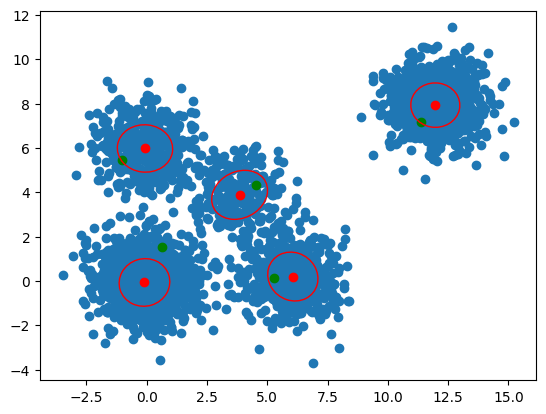

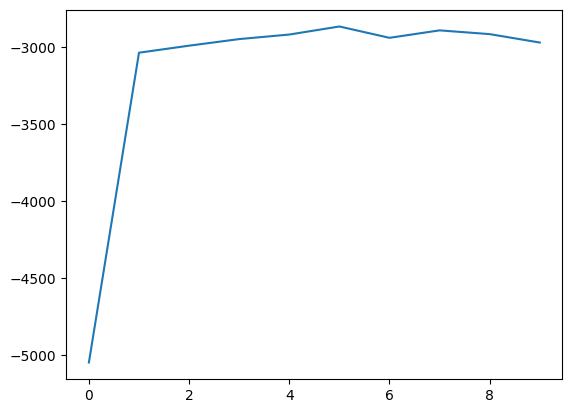

In [178]:
#SVI

#code from test_metaobs
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmsgd_metaobs as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


from pybasicbayes import distributions as dist
from generate_data import *

from sklearn.cluster import KMeans

maxit = 10
metaobs_half = 1
mb_sz = 100

hmm_sgd_bad = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit, maxit=maxit, metaobs_half=metaobs_half, mb_sz=mb_sz)
hmm_sgd_bad.infer()
full_var_x = hmm_sgd_bad.full_local_update()

#sts_true = np.array([int(np.round(i/N)) for i in range(N)])
# hamming distance
print('Hamming Distance = ', hmm_sgd_bad.hamming_dist(full_var_x, seq)[0])

# plot learned emissions over observations
util.plot_emissions(obs, prior_emit, hmm_sgd_bad.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm_sgd_bad.elbo_vec)
plt.show()

In [179]:
SVI_mus_b = {}
SVI_sig_b = {}
SVI_kapp_b = {}
SVI_nu_b = {}
SVI_alphas_b = {}

true_map_SVI_b = [np.argmin(np.sqrt(np.sum((hmm_sgd_bad.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(5)]

for i in range(0,len(hmm_sgd_bad.var_emit)):
    SVI_mus_b[str(true_map_SVI_b[i])] = hmm_sgd_bad.var_emit[i].mu_mf
    SVI_sig_b[str(true_map_SVI_b[i])] = hmm_sgd_bad.var_emit[i].sigma_mf
    SVI_kapp_b[str(true_map_SVI_b[i])] = hmm_sgd_bad.var_emit[i].kappa_mf
    SVI_nu_b[str(true_map_SVI_b[i])] = hmm_sgd_bad.var_emit[i].nu_mf
    SVI_alphas_b[str(true_map_SVI_b[i])] = {}
    for j in range(0,len(hmm_sgd_bad.var_emit)):
        SVI_alphas_b[str(true_map_SVI[i])][str(true_map_SVI_b[j])] = hmm_sgd_bad.var_tran[i][j]

In [161]:
SVI_mus = {}
SVI_sig = {}
SVI_kapp = {}
SVI_nu = {}
SVI_alphas = {}

true_map_SVI = [np.argmin(np.sqrt(np.sum((hmm_sgd.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(5)]

for i in range(0,len(hmm_sgd.var_emit)):
    SVI_mus[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].mu_mf
    SVI_sig[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].sigma_mf
    SVI_kapp[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].kappa_mf
    SVI_nu[str(true_map_SVI[i])] = hmm_sgd.var_emit[i].nu_mf
    SVI_alphas[str(true_map_SVI[i])] = {}
    for j in range(0,len(hmm_sgd.var_emit)):
        SVI_alphas[str(true_map_SVI[i])][str(true_map_SVI[j])] = hmm_sgd.var_tran[i][j]

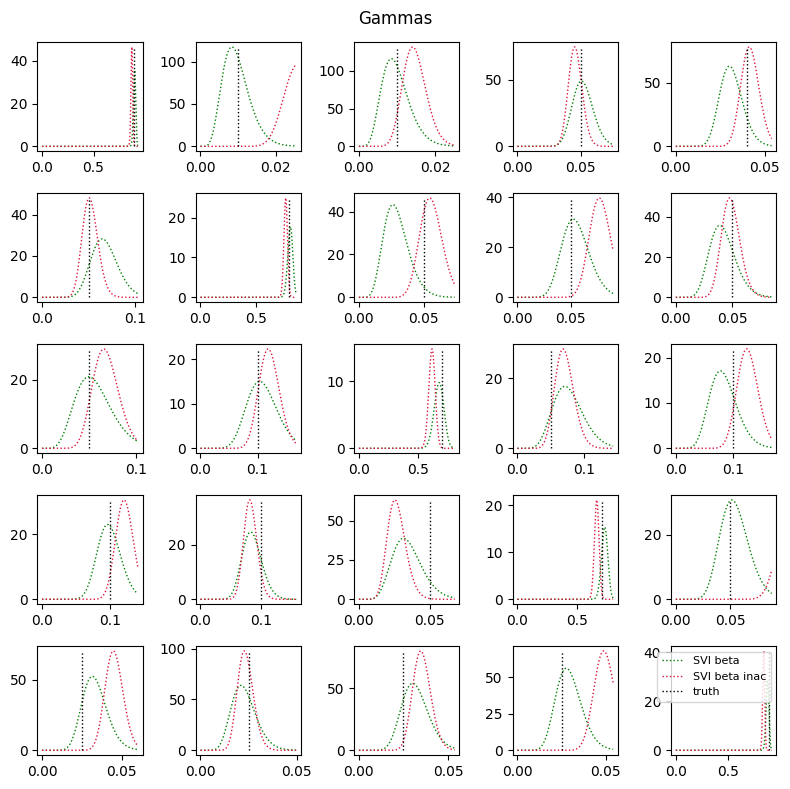

In [180]:
#gammas
K=5
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        ax = axs[k,j]
        
        #xs
        #x = np.linspace(0,2*T[k][j],500)
        x = np.linspace(0,max(MCMC_gamm[str(k+1)][str(j+1)]),500)

        #SVI
        dist1 = beta.pdf(x,SVI_alphas[str(k+1)][str(j+1)] , sum(SVI_alphas[str(k+1)].values())-SVI_alphas[str(k+1)][str(j+1)])
        ax.plot(x, dist1,label = 'SVI beta',color = 'green',linewidth=1.0,linestyle = 'dotted')

        #SVI
        dist2 = beta.pdf(x,SVI_alphas_b[str(k+1)][str(j+1)] , sum(SVI_alphas_b[str(k+1)].values())-SVI_alphas_b[str(k+1)][str(j+1)])
        ax.plot(x, dist2,label = 'SVI beta inac',color = 'crimson',linewidth=1.0,linestyle = 'dotted')
        
        h_max = max(np.max(dist2),np.max(dist1))
        ax.vlines(T[k][j],0,h_max,color = 'black',label='truth',linewidth=1.0,linestyle = 'dotted')
        
        # ax.set_xlim(0,1)
        ax.set(ylabel=None)


plt.suptitle('Gammas')
plt.legend(fontsize = 8)
plt.tight_layout()

In [148]:
#adaptar
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        sns.kdeplot(MCMC_mus[str(k+1)].T[d],label='MCMC density',ax=ax,color = 'royalblue')

        x = np.linspace(min(MCMC_mus[str(k+1)].T[d]+0.00001),max(MCMC_mus[str(k+1)].T[d]),500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        dist1 = t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))
        ax.plot(x, dist1,label = 'VI',color = 'orange')
        
        #SVI
        scale_kd = np.diag(SVI_sig[str(k+1)])[d] / (SVI_kapp[str(k+1)]*( SVI_nu[str(k+1)] + D - 1 ))
        
        dist2 = t.pdf(x, df = SVI_nu[str(k+1)], loc=SVI_mus[str(k+1)][d], scale=np.sqrt(scale_kd))
        ax.plot(x, dist2,label = 'SVI',color = 'crimson')
        
        h_max = max(np.max(dist2),np.max(dist1), np.max(MCMC_mus[str(k+1)].T[d]))
        
        h_max=13

        ax.vlines(np.mean(MCMC_mus[str(k+1)].T[d]),0, h_max,linestyles='dotted',linewidth = 2, label='MCMC mean',color = 'royalblue')
        
        ax.vlines(VI_mus[str(k+1)][d],0,h_max,color = 'orange',label='VI',linestyles='dashed')

        ax.vlines(SVI_mus[str(k+1)][d],0,h_max,color = 'crimson',label='SVI',linestyles='dashed')
        
        ax.vlines(centers[k][d],0,h_max,color = 'black',label='truth')
        
        plt.ylim((0,h_max))
        
plt.suptitle('Mus (mean) students-t approximation')
legend = plt.legend(fontsize = 8)
plt.tight_layout()

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)


In [ ]:
#sigmas
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        ax.vlines(1,0,10,color = 'black',label='truth')

        ax.vlines(np.mean(MCMC_sig[str(k+1)][:][:,d,d]),0,10,color = 'royalblue',linestyles='dotted',linewidth = 2, label='MCMC mean')

        sns.kdeplot(MCMC_sig[str(k+1)][:][:,d,d],label='MCMC density',ax=ax,color='royalblue')

        x = np.linspace(0.1,3,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI',color = 'orange')
        
        iw = invwishart.pdf(x, df=SVI_kapp[str(k+1)], scale = np.diag(SVI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'SVI',color = 'crimson')
        
        ax.sharex(axs[:][d][0])
        
        ax.set_xlim(0,2.5)

plt.suptitle('Sigmas (variance) Inverse Wishart approximation')
plt.legend(fontsize = 8)
plt.tight_layout()

